In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))


from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)
    

In [2]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

In [3]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [4]:
# Aggregate all predictions of each model for exp3

all_stores_upc = {}
for store, upc in full_search:
    xgb_exp3 =[]
    xgb_exp4 =[]
    lstm_exp3 =[]
    lstm_exp4 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        if 'olist' in fpath:
            pass
        else:
            xgb_exp3.append(pd.read_csv(os.path.join(fpath,f'xgb_exp3_{store}_{upc}.csv')))
            xgb_exp4.append(pd.read_csv(os.path.join(fpath,f'xgb_exp4_{store}_{upc}.csv')))
            lstm_exp3.append(pd.read_csv(os.path.join(fpath,f'lstm_exp3_{store}_{upc}.csv')))
            lstm_exp4.append(pd.read_csv(os.path.join(fpath,f'lstm_exp4_{store}_{upc}.csv')))

    xgb_exp3 = pd.concat(xgb_exp3).reset_index(drop=True)
    xgb_exp4 = pd.concat(xgb_exp4).reset_index(drop=True)
    lstm_exp3 = pd.concat(lstm_exp3).reset_index(drop=True)
    lstm_exp4 = pd.concat(lstm_exp4).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp3 = xgb_exp3.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    xgb_exp4 = xgb_exp4.rename(columns={'test_predictions':'y_pred_xgb_gtrend',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb_gtrend','y_true']]
    lstm_exp3['dates'] = xgb_exp3['dates']
    lstm_exp3.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp3 = lstm_exp3.rename(columns={'y_pred':'y_pred_lstm'})
    lstm_exp4['dates'] = xgb_exp3['dates']
    lstm_exp4.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp4 = lstm_exp4.rename(columns={'y_pred':'y_pred_lstm_gtrend'})
    
    xgb_exp3.set_index('dates', inplace=True)
    xgb_exp4.set_index('dates', inplace=True)
    lstm_exp3.set_index('dates', inplace=True)
    lstm_exp4.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp3[['y_true','y_pred_xgb']],
                    xgb_exp4['y_pred_xgb_gtrend'],
                    lstm_exp3['y_pred_lstm'],
                    lstm_exp4['y_pred_lstm_gtrend']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df

In [5]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()]})
    

In [6]:
metrics_df = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        results = results.merge(min_max_df, how='inner',on='model')  

        # Calculate the minimum and maximum of each fold.
        metrics_df = metrics_df.append(results).reset_index(drop=True)

In [7]:
metrics_df

model          wape        rmse        r2      mape  store  \
0           xgb  12215.789412  102.982168 -0.231999  0.298653   2277   
1    xgb_gtrend  11948.246724   99.742553 -0.155706  0.234083   2277   
2          lstm  12012.669579   97.952324 -0.114592  0.197837   2277   
3   lstm_gtrend  11950.718006   99.018672 -0.138992  0.235992   2277   
4           xgb   4212.795837   63.865694 -0.447418  0.387303   2277   
..          ...           ...         ...       ...       ...    ...   
91  lstm_gtrend    429.788347   16.639875 -0.152851  0.289006  25229   
92          xgb    353.059932   14.525880 -0.076108  0.300793  25229   
93   xgb_gtrend    349.295211   15.879491 -0.286010  0.376636  25229   
94         lstm    353.059932   14.525880 -0.076108  0.300793  25229   
95  lstm_gtrend    349.295211   15.879491 -0.286010  0.376636  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        4.0        4.0        4.0      1.0  146.950000   
1   1600027527        2.0        1.0        3.0      2.0  197.135714   
2   1600027527        1.0        3.0        1.0      4.0  108.386655   
3   1600027527        3.0        2.0        2.0      3.0  169.872306   
4   3800031838        3.0        3.0        3.0      2.0  146.950000   
..         ...        ...        ...        ...      ...         ...   
91  1111009477        3.5        3.5        3.5      1.5  169.872306   
92  7192100339        1.5        3.5        1.5      3.5  146.950000   
93  7192100339        3.5        1.5        3.5      1.5  197.135714   
94  7192100339        1.5        3.5        1.5      3.5  108.386655   
95  7192100339        3.5        1.5        3.5      1.5  169.872306   

     min_rmse     min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  
0    5.958188 -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809  
1   10.210289 -35.219512  0.222823  1434.300000  32.202484 -0.736983  1.066447  
2    5.709083 -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507  
3    5.565220 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980  
4    5.958188 -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809  
..        ...        ...       ...          ...        ...       ...       ...  
91   5.565220 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980  
92   5.958188 -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809  
93  10.210289 -35.219512  0.222823  1434.300000  32.202484 -0.736983  1.066447  
94   5.709083 -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507  
95   5.565220 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980  

[96 rows x 19 columns]

In [8]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
        if model =='lstm':
            metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)

In [9]:
metrics_df_xgb

model          wape        rmse        r2      mape  store  \
0          xgb  12215.789412  102.982168 -0.231999  0.298653   2277   
1   xgb_gtrend  11948.246724   99.742553 -0.155706  0.234083   2277   
2          xgb   4212.795837   63.865694 -0.447418  0.387303   2277   
3   xgb_gtrend   4375.541770   72.257685 -0.852793  0.474332   2277   
4          xgb   7665.640777   66.140730 -1.447318  0.282308   2277   
5   xgb_gtrend   6702.263194   56.219522 -0.768181  0.235786   2277   
6          xgb   2256.236002   51.319137 -0.988972  0.691072   2277   
7   xgb_gtrend   2143.821167   51.700134 -1.018614  0.678832   2277   
8          xgb   6117.432484   78.514942 -0.331319  0.380455    389   
9   xgb_gtrend   4257.831746   76.219319 -0.254607  0.490992    389   
10         xgb   5002.798372   77.002997 -0.353528  0.484059    389   
11  xgb_gtrend   4821.965137   70.918832 -0.148088  0.353661    389   
12         xgb   1598.077602   30.174174 -1.346593  0.233914    389   
13  xgb_gtrend   1596.298869   28.666518 -1.117956  0.199730    389   
14         xgb   1151.300969   36.018692 -0.492578  0.575566    389   
15  xgb_gtrend   1113.051126   38.495005 -0.704865  0.801059    389   
16         xgb   6075.751935   94.045100 -0.660263  0.425395  25229   
17  xgb_gtrend   6042.185212   83.422926 -0.306398  0.449664  25229   
18         xgb   2251.842481   54.158066 -0.899419  0.389524  25229   
19  xgb_gtrend   2087.602636   52.299985 -0.771322  0.324193  25229   
20         xgb    593.596513   22.603608 -1.127299  0.392308  25229   
21  xgb_gtrend    548.332495   21.146013 -0.861787  0.321067  25229   
22         xgb    491.606971   20.777206 -1.201635  0.407256  25229   
23  xgb_gtrend    505.051202   22.321084 -1.540982  0.495176  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        2.0        2.0        2.0      1.0  146.950000   
1   1600027527        1.0        1.0        1.0      2.0  197.135714   
2   3800031838        1.0        1.0        1.0      2.0  146.950000   
3   3800031838        2.0        2.0        2.0      1.0  197.135714   
4   1111009477        2.0        2.0        2.0      1.0  146.950000   
5   1111009477        1.0        1.0        1.0      2.0  197.135714   
6   7192100339        2.0        2.0        1.0      2.0  146.950000   
7   7192100339        1.0        1.0        2.0      1.0  197.135714   
8   1600027527        1.0        2.0        2.0      1.0  146.950000   
9   1600027527        2.0        1.0        1.0      2.0  197.135714   
10  3800031838        2.0        2.0        2.0      1.0  146.950000   
11  3800031838        1.0        1.0        1.0      2.0  197.135714   
12  1111009477        2.0        2.0        2.0      1.0  146.950000   
13  1111009477        1.0        1.0        1.0      2.0  197.135714   
14  7192100339        1.0        2.0        1.0      2.0  146.950000   
15  7192100339        2.0        1.0        2.0      1.0  197.135714   
16  1600027527        1.0        2.0        2.0      1.0  146.950000   
17  1600027527        2.0        1.0        1.0      2.0  197.135714   
18  3800031838        2.0        2.0        2.0      1.0  146.950000   
19  3800031838        1.0        1.0        1.0      2.0  197.135714   
20  1111009477        2.0        2.0        2.0      1.0  146.950000   
21  1111009477        1.0        1.0        1.0      2.0  197.135714   
22  7192100339        1.0        1.0        1.0      2.0  146.950000   
23  7192100339        2.0        2.0        2.0      1.0  197.135714   

     min_rmse     min_r2  min_mape  max_wape   max_rmse    max_r2  max_mape  
0    5.958188 -35.969697  0.139971    1434.3  31.815877 -0.203390  0.610809  
1   10.210289 -35.219512  0.222823    1434.3  32.202484 -0.736983  1.066447  
2    5.958188 -35.969697  0.139971    1434.3  31.815877 -0.203390  0.610809  
3   10.210289 -35.219512  0.222823    1434.3  32.202484 -0.736983  1.066447  
4    5.958188 -35.969697  0.139971    1434

In [10]:
metrics_df_lstm

model          wape       rmse        r2      mape  store  \
0          lstm  12012.669579  97.952324 -0.114592  0.197837   2277   
1   lstm_gtrend  11950.718006  99.018672 -0.138992  0.235992   2277   
2          lstm   3623.493802  54.085438 -0.038053  0.270570   2277   
3   lstm_gtrend   3642.001788  55.218231 -0.081991  0.319996   2277   
4          lstm   6880.783608  51.710914 -0.495950  0.198024   2277   
5   lstm_gtrend   6017.526830  47.159926 -0.244224  0.183228   2277   
6          lstm   1729.367917  36.801724 -0.022837  0.490326   2277   
7   lstm_gtrend   1776.952399  38.247359 -0.104772  0.520766   2277   
8          lstm   5991.373173  77.454043 -0.295585  0.562403    389   
9   lstm_gtrend   5943.593968  75.471145 -0.230097  0.484659    389   
10         lstm   4448.442203  65.720123  0.014064  0.446804    389   
11  lstm_gtrend   5029.091805  74.746592 -0.275365  0.482191    389   
12         lstm   1256.183036  20.842428 -0.119602  0.163209    389   
13  lstm_gtrend   1353.363536  23.833683 -0.464028  0.169796    389   
14         lstm    932.032212  29.724763 -0.016525  0.667623    389   
15  lstm_gtrend   1047.514931  33.391206 -0.282760  0.710955    389   
16         lstm   5681.819501  74.016232 -0.028392  0.361673  25229   
17  lstm_gtrend   5641.904289  75.903472 -0.081504  0.481136  25229   
18         lstm   1922.389140  40.005022 -0.036391  0.236757  25229   
19  lstm_gtrend   1848.025802  39.262374  0.001731  0.287618  25229   
20         lstm    396.089870  16.089919 -0.077906  0.286553  25229   
21  lstm_gtrend    429.788347  16.639875 -0.152851  0.289006  25229   
22         lstm    353.059932  14.525880 -0.076108  0.300793  25229   
23  lstm_gtrend    349.295211  15.879491 -0.286010  0.376636  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        1.0        2.0        1.0      2.0  108.386655   
1   1600027527        2.0        1.0        2.0      1.0  169.872306   
2   3800031838        1.0        1.0        1.0      2.0  108.386655   
3   3800031838        2.0        2.0        2.0      1.0  169.872306   
4   1111009477        2.0        2.0        2.0      1.0  108.386655   
5   1111009477        1.0        1.0        1.0      2.0  169.872306   
6   7192100339        1.0        1.0        1.0      2.0  108.386655   
7   7192100339        2.0        2.0        2.0      1.0  169.872306   
8   1600027527        2.0        2.0        2.0      1.0  108.386655   
9   1600027527        1.0        1.0        1.0      2.0  169.872306   
10  3800031838        1.0        1.0        1.0      2.0  108.386655   
11  3800031838        2.0        2.0        2.0      1.0  169.872306   
12  1111009477        1.0        1.0        1.0      2.0  108.386655   
13  1111009477        2.0        2.0        2.0      1.0  169.872306   
14  7192100339        1.0        1.0        1.0      2.0  108.386655   
15  7192100339        2.0        2.0        2.0      1.0  169.872306   
16  1600027527        1.0        2.0        1.0      2.0  108.386655   
17  1600027527        2.0        1.0        2.0      1.0  169.872306   
18  3800031838        1.0        2.0        2.0      1.0  108.386655   
19  3800031838        2.0        1.0        1.0      2.0  169.872306   
20  1111009477        1.0        1.0        1.0      2.0  108.386655   
21  1111009477        2.0        2.0        2.0      1.0  169.872306   
22  7192100339        1.0        2.0        1.0      2.0  108.386655   
23  7192100339        2.0        1.0        2.0      1.0  169.872306   

    min_rmse     min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  
0   5.709083 -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507  
1   5.565220 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980  
2   5.709083 -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507  
3   5.565220 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980  
4   5.709083 -12.837301  0.123403

In [11]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

In [12]:
# View combined of the ranks for each metrics per model
# metrics_df.drop(columns=['rank_mape','rank_wape', 'rank_rmse','rank_r2'])

In [13]:
pd.concat(all_dfs_xgb,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2
model                                                                 
xgb              5       7       4       8       2      10     8     4
xgb_gtrend       7       5       8       4      10       2     4     8

In [14]:
pd.concat(all_dfs_lstm,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2
model                                                                  
lstm             10       2       9       3       6       6     3     9
lstm_gtrend       2      10       3       9       6       6     9     3

In [15]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

rank_mape   mape_1  mape_2
model                     
xgb              5       7
xgb_gtrend       7       5

rank_rmse   rmse_1  rmse_2
model                     
xgb              4       8
xgb_gtrend       8       4

rank_wape   wape_1  wape_2
model                     
xgb              2      10
xgb_gtrend      10       2

rank_r2     r2_1  r2_2
model                 
xgb            8     4
xgb_gtrend     4     8

In [16]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

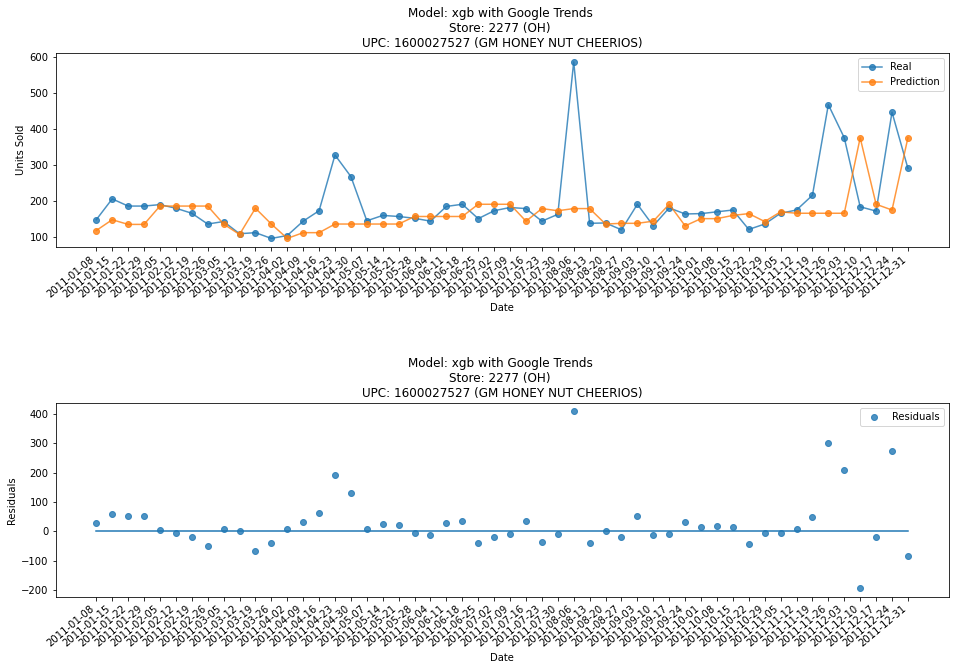

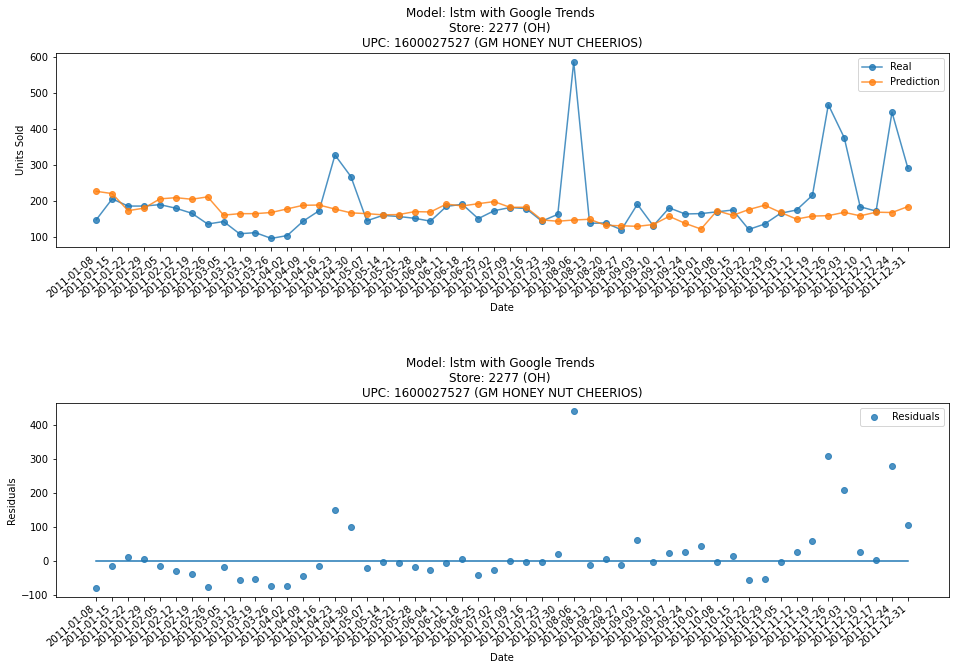

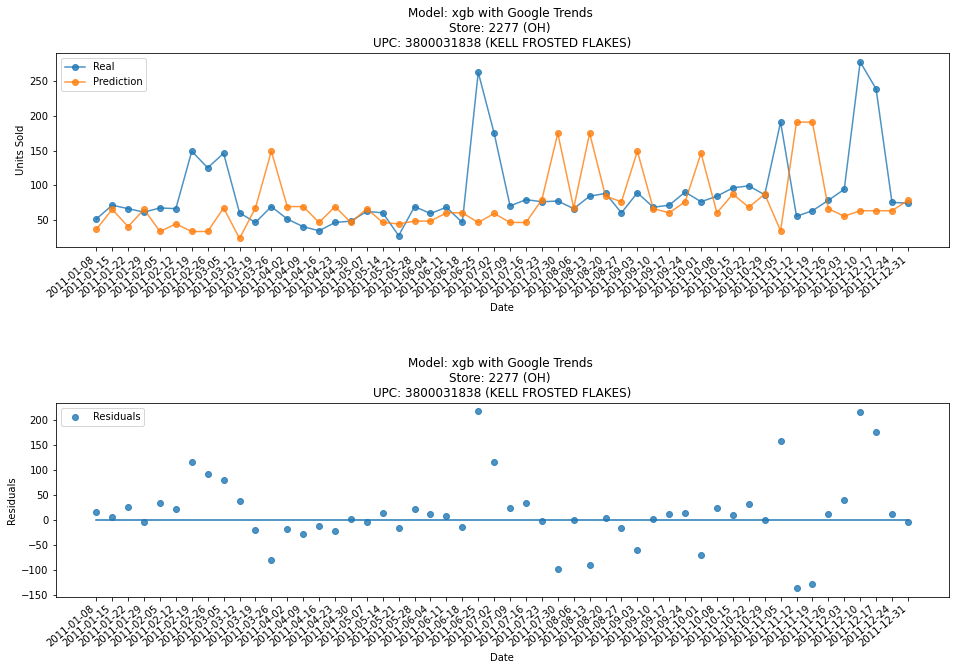

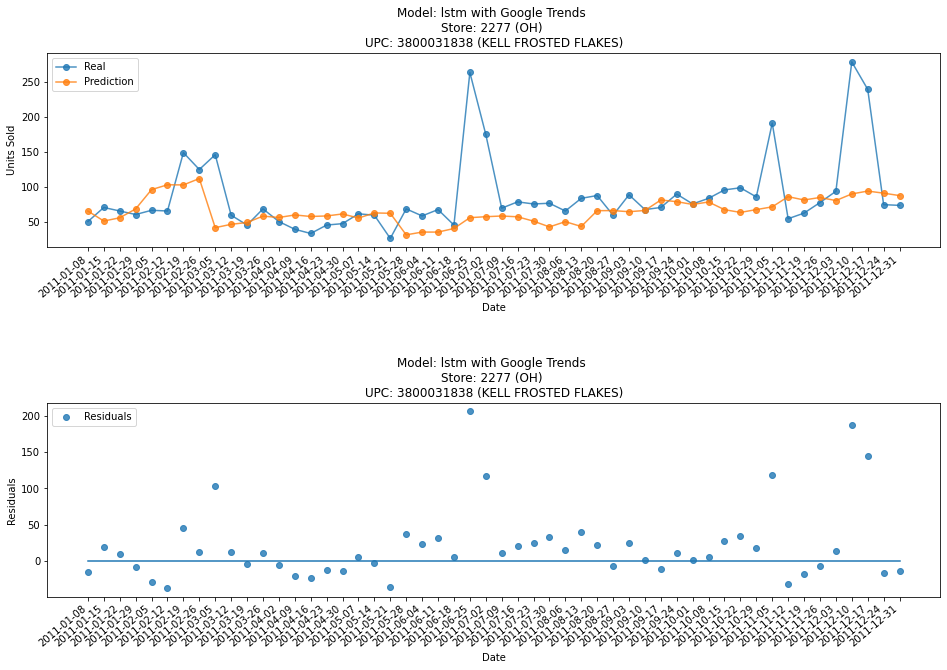

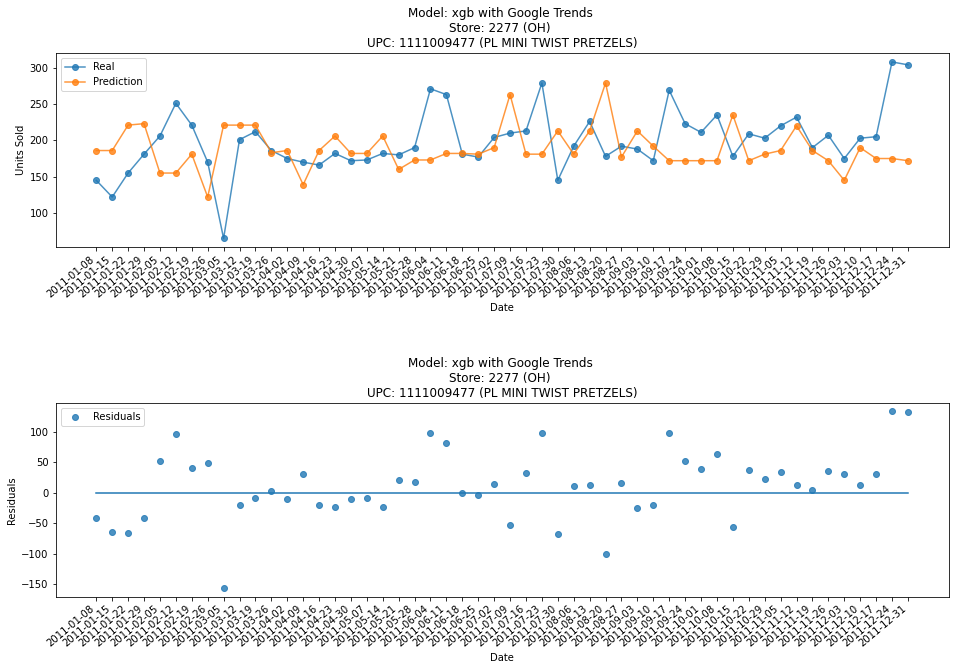

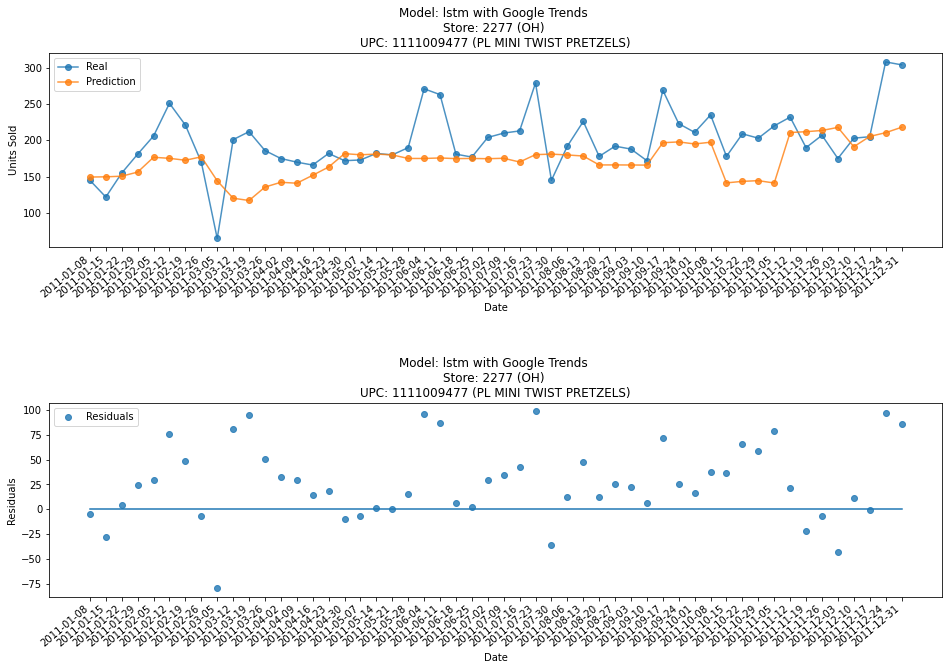

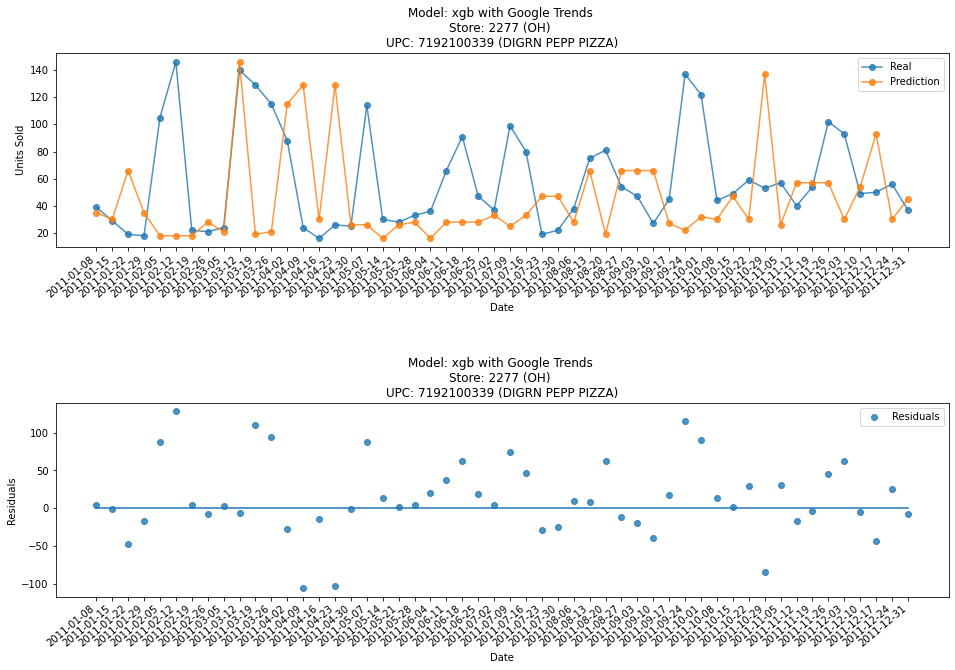

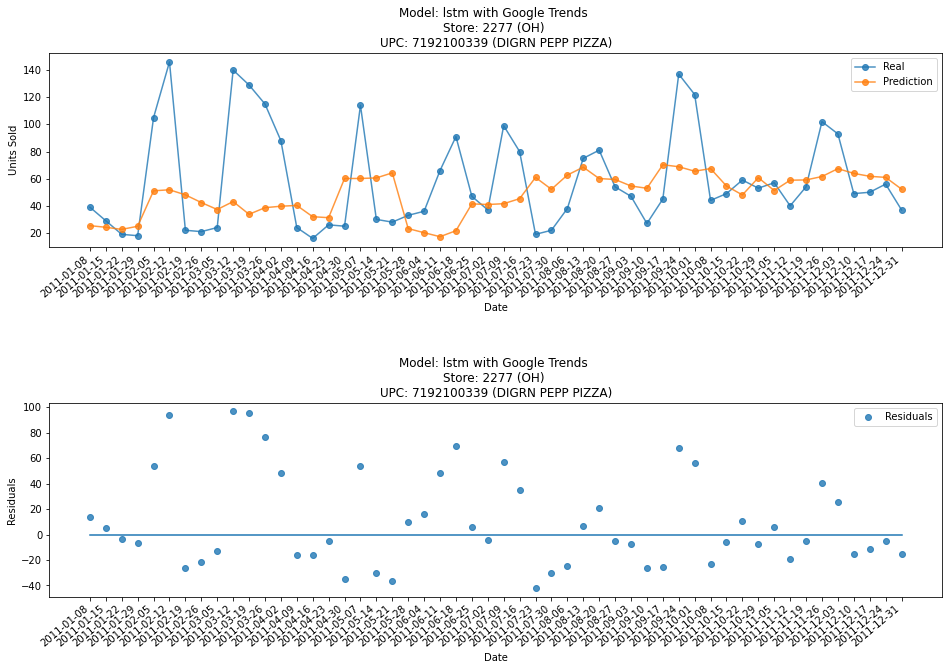

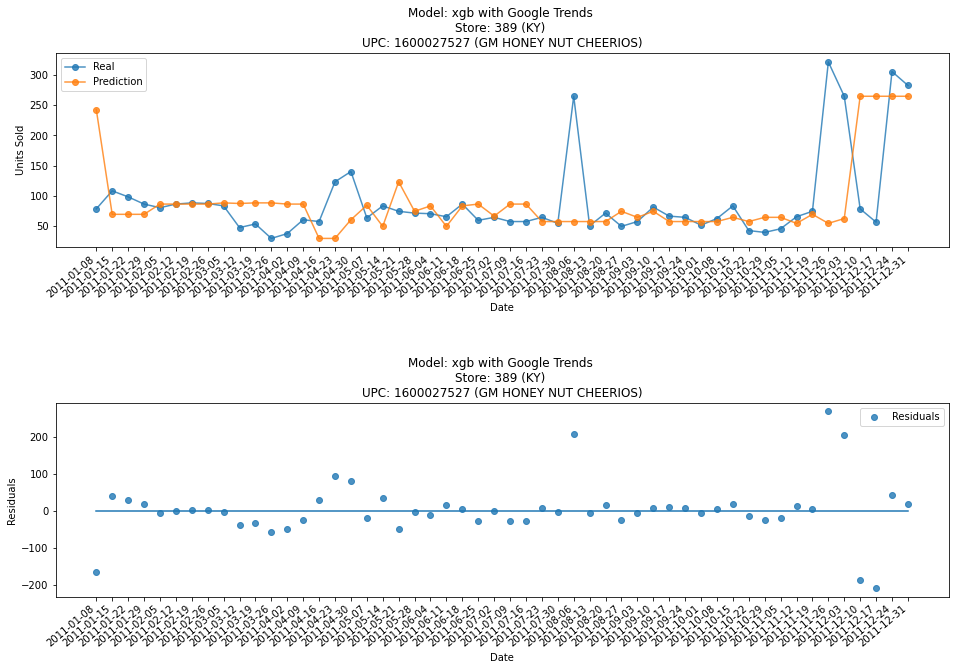

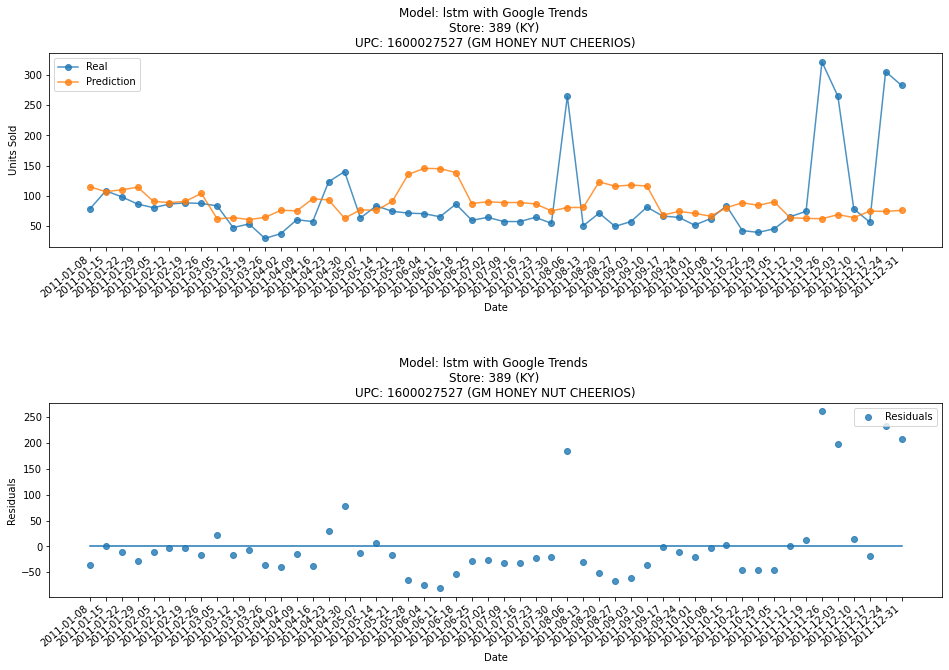

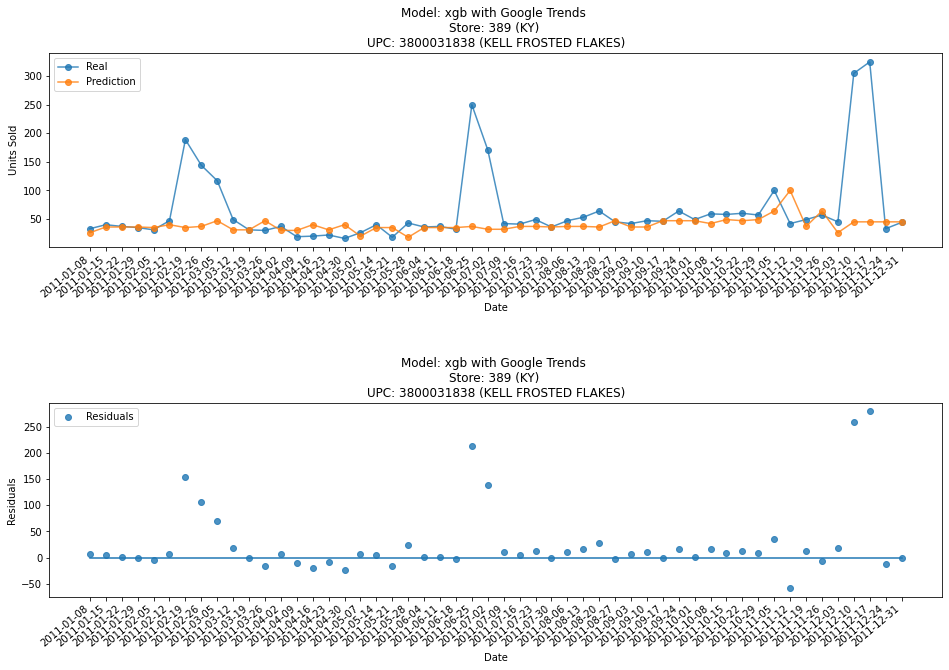

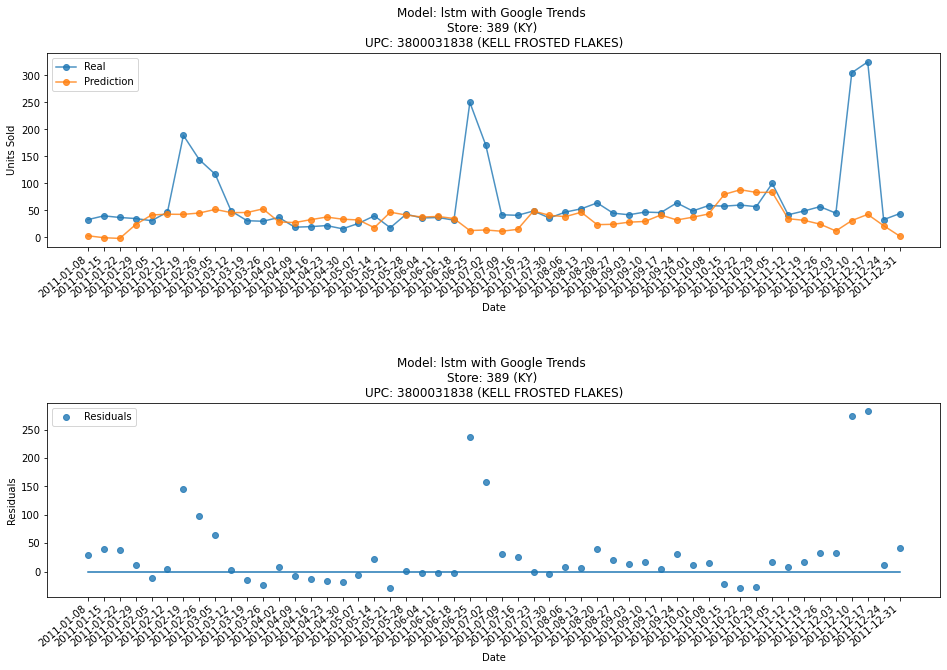

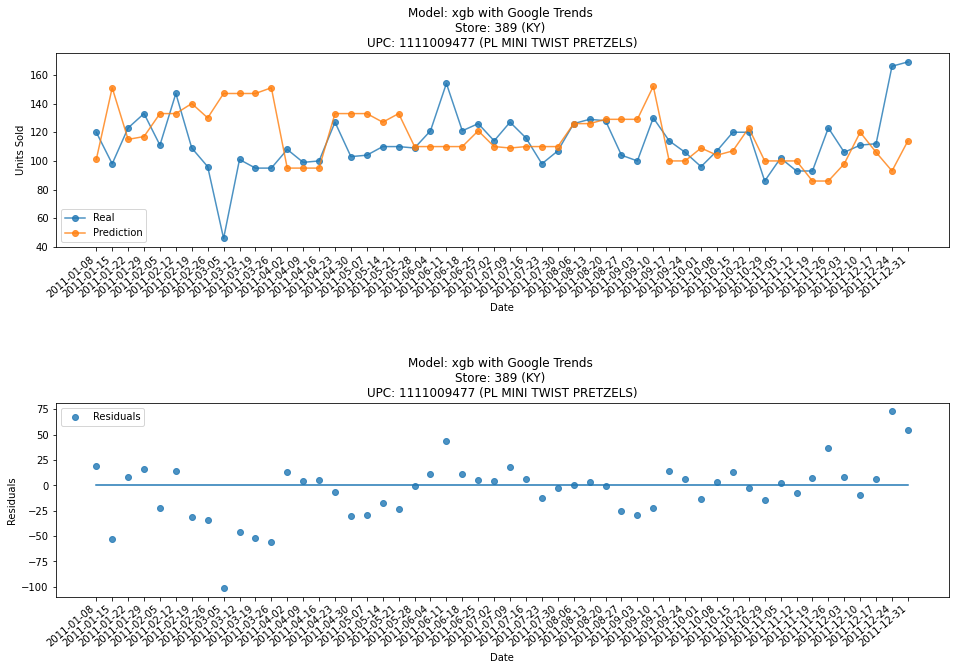

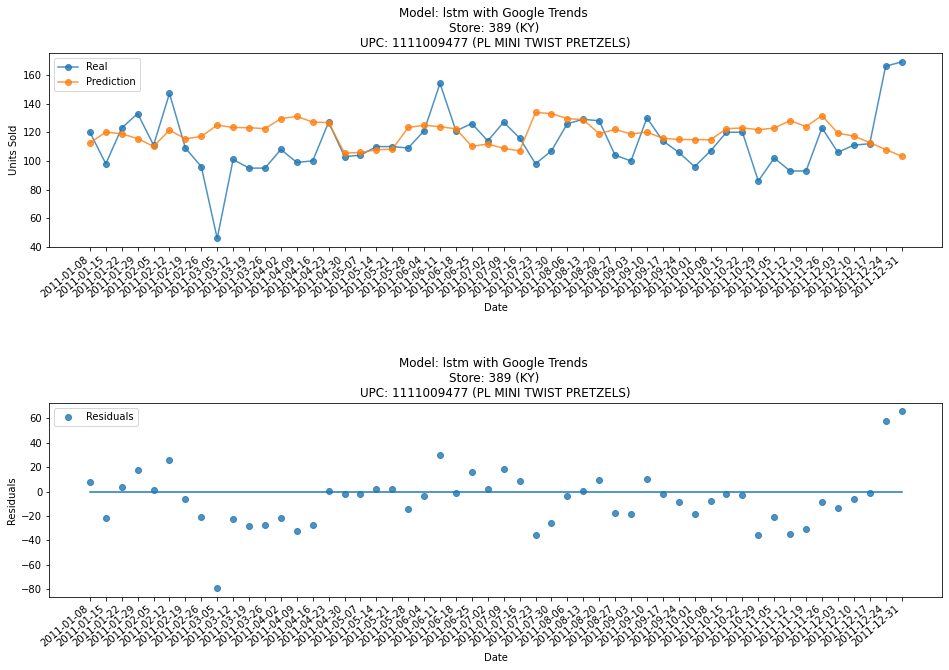

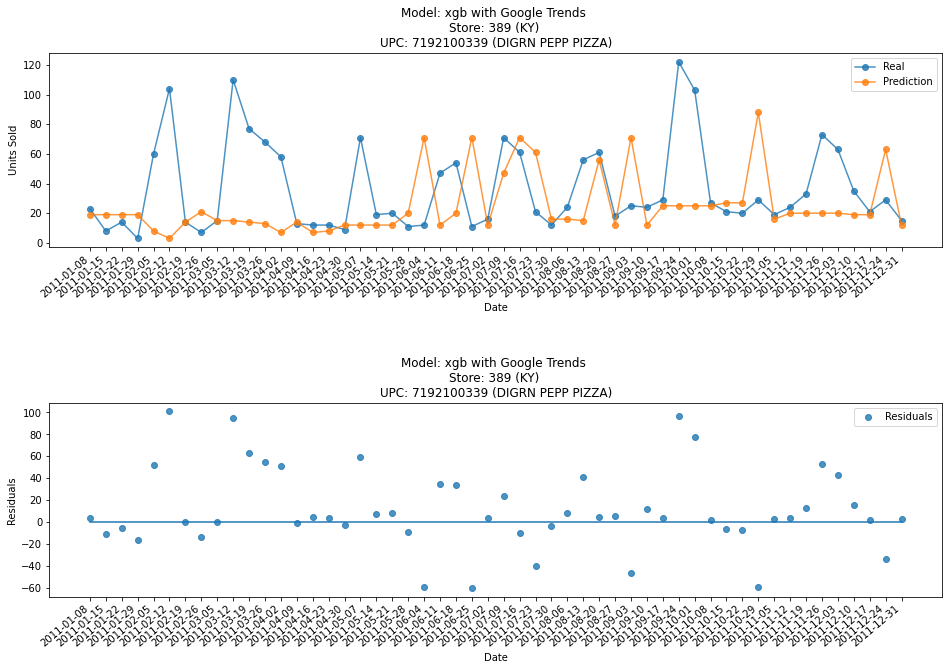

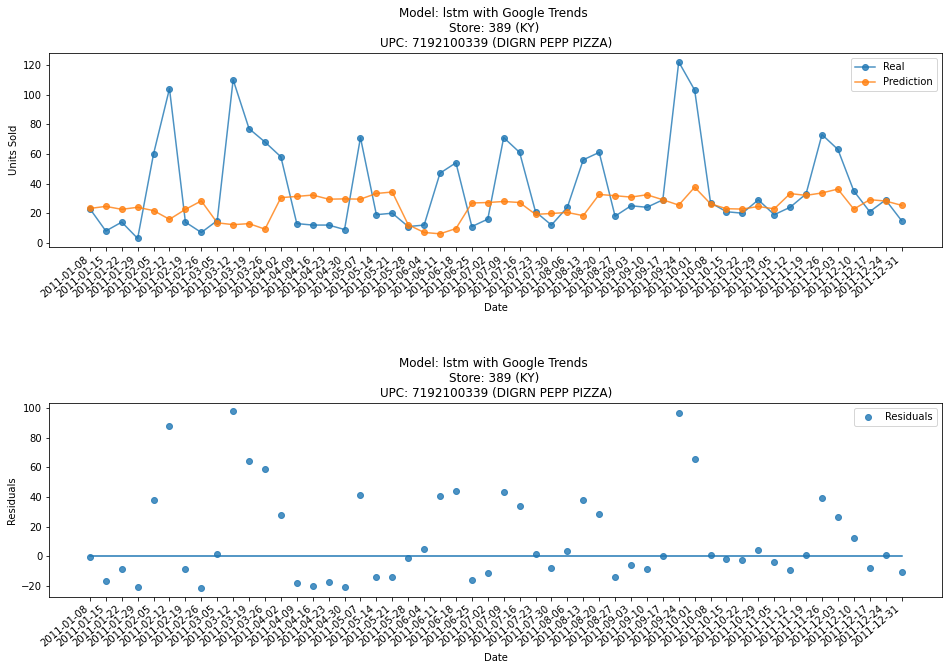

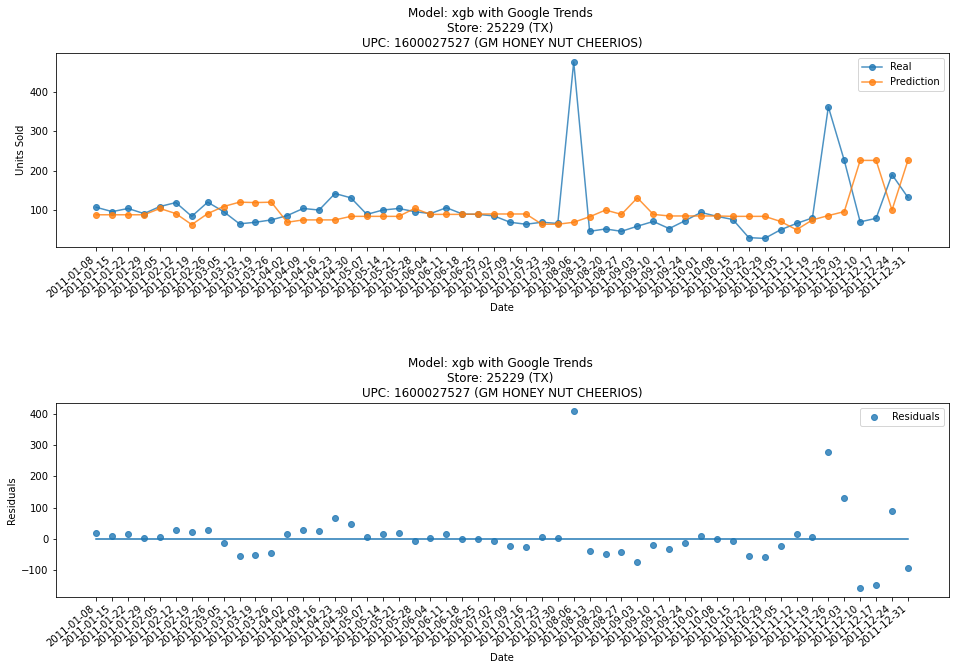

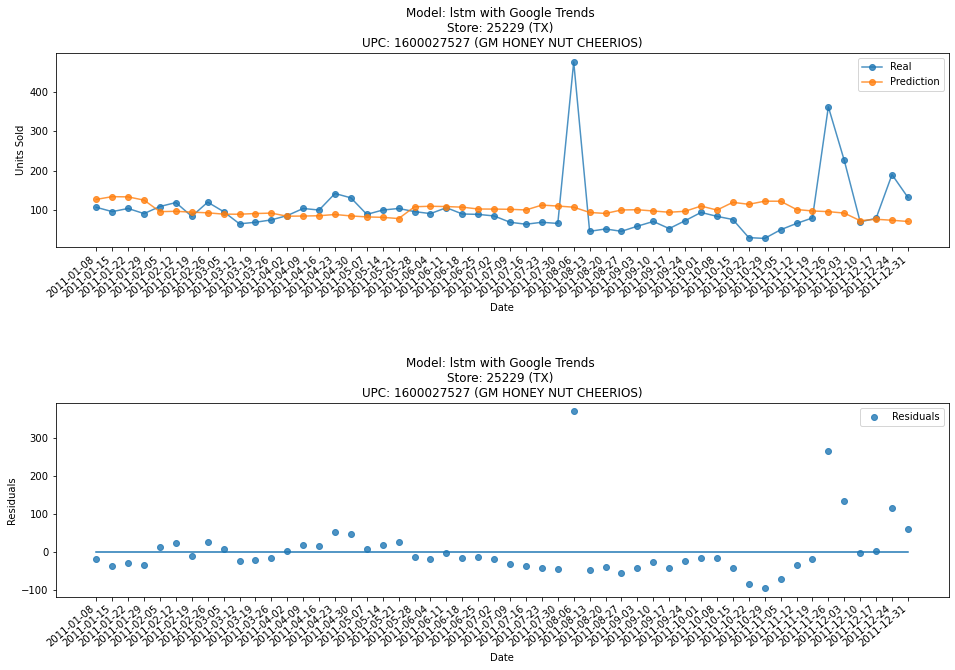

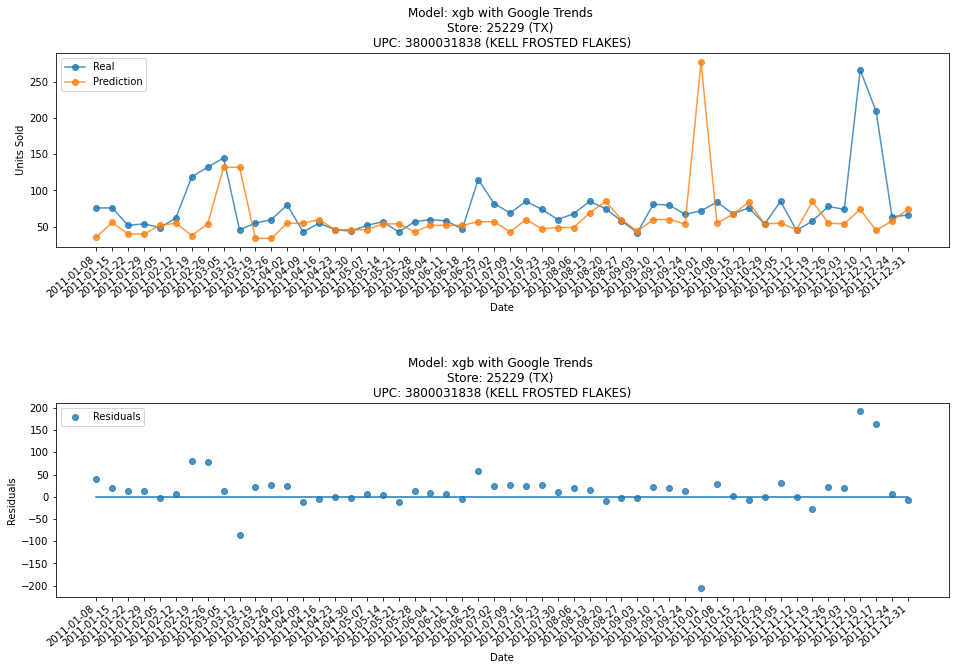

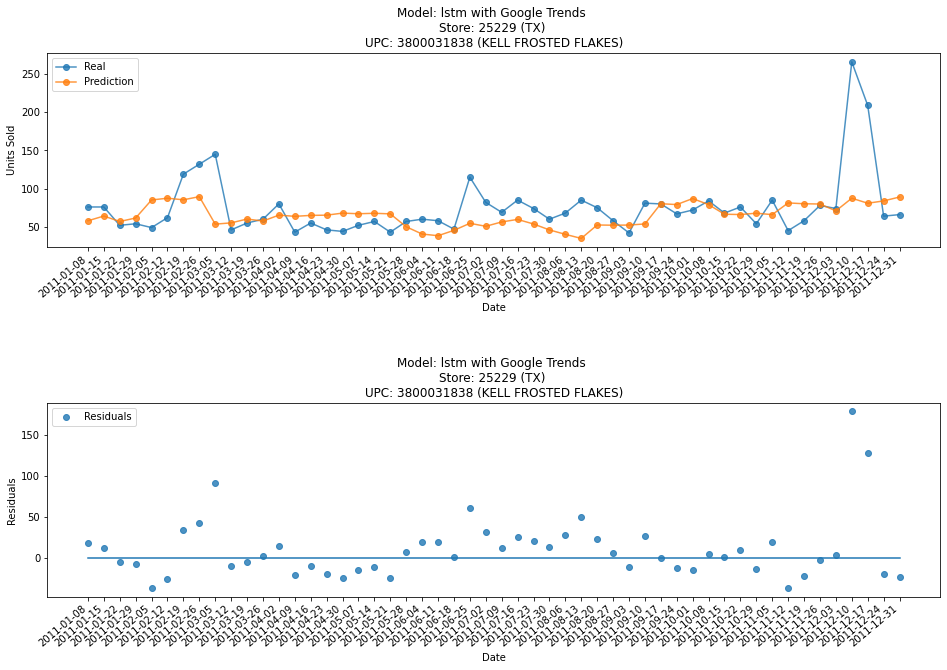

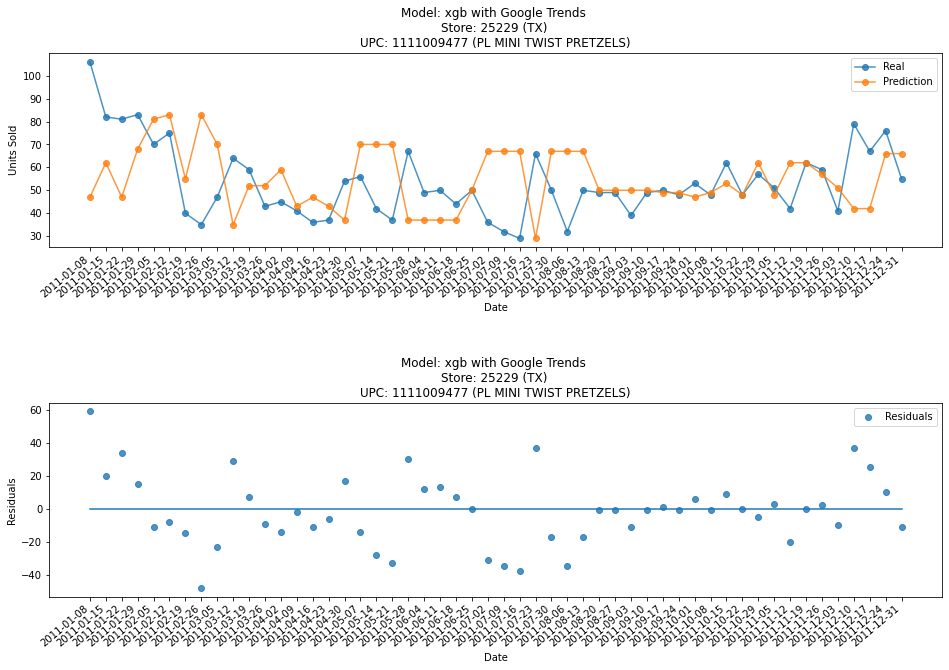

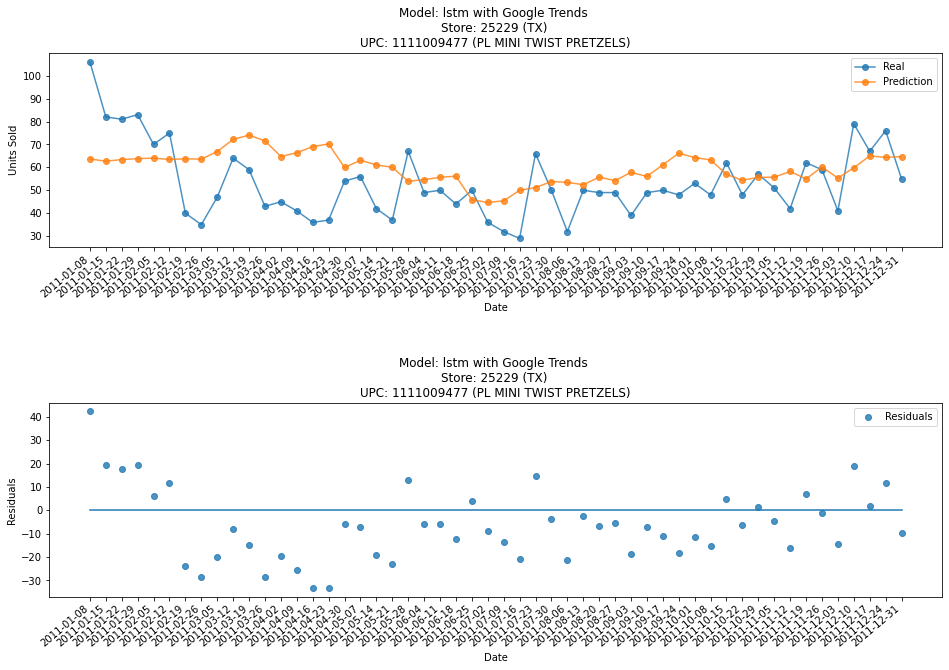

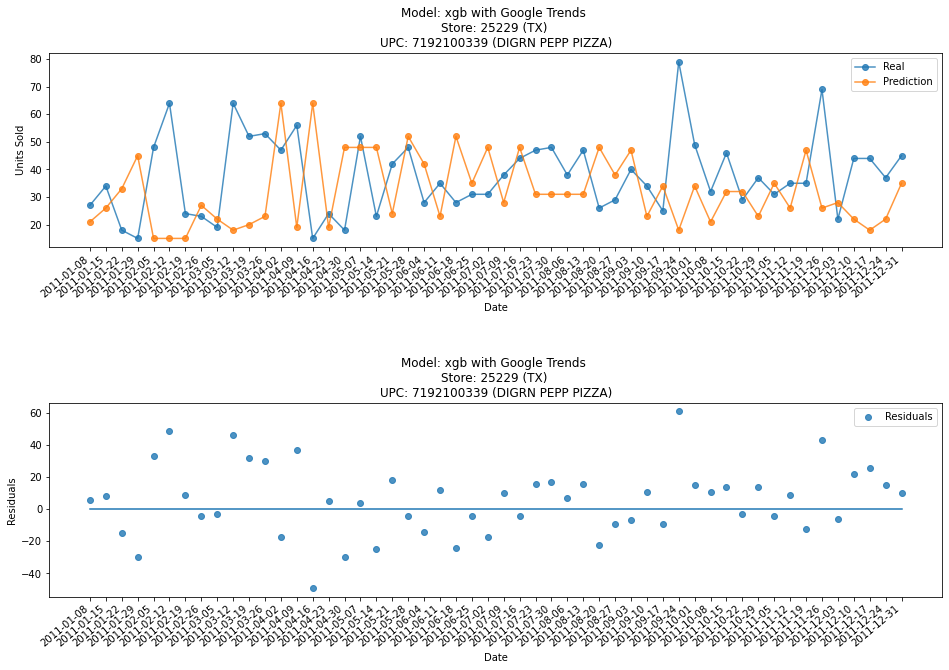

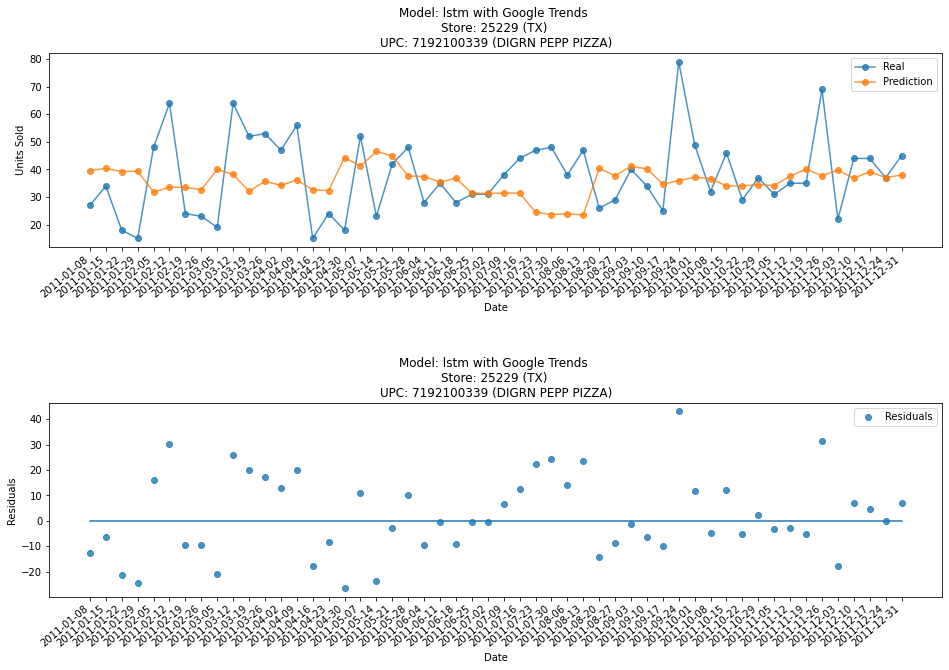

In [22]:
# Plot the forecast for each model (Only Google Trends)
for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

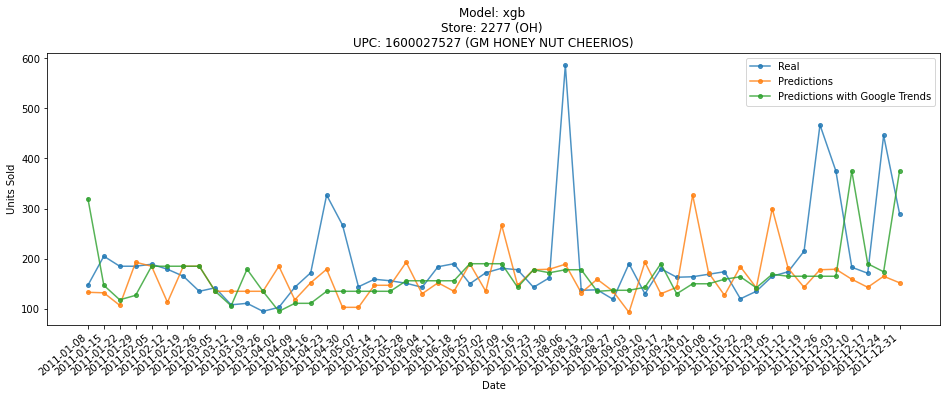

Std xgb: 43.96 and with Google Trends: 53.92


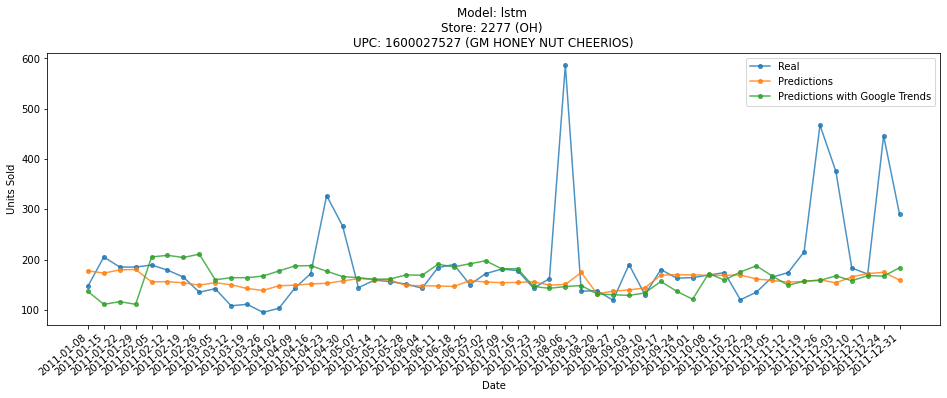

Std lstm: 11.28 and with Google Trends: 24.71






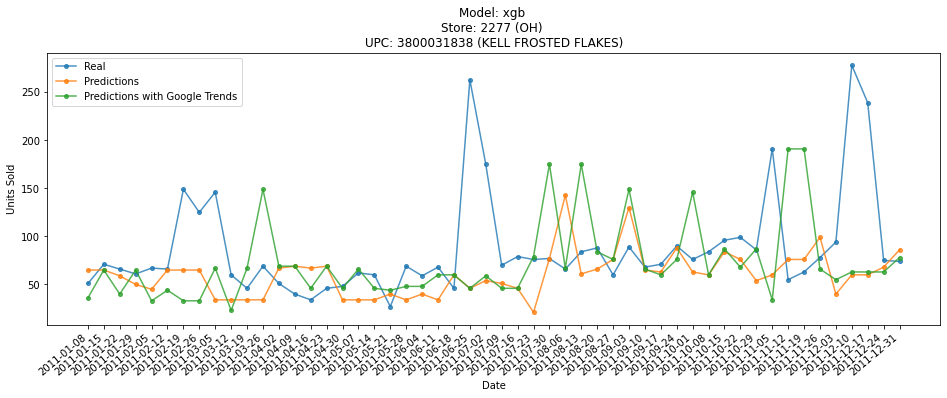

Std xgb: 22.95 and with Google Trends: 41.22


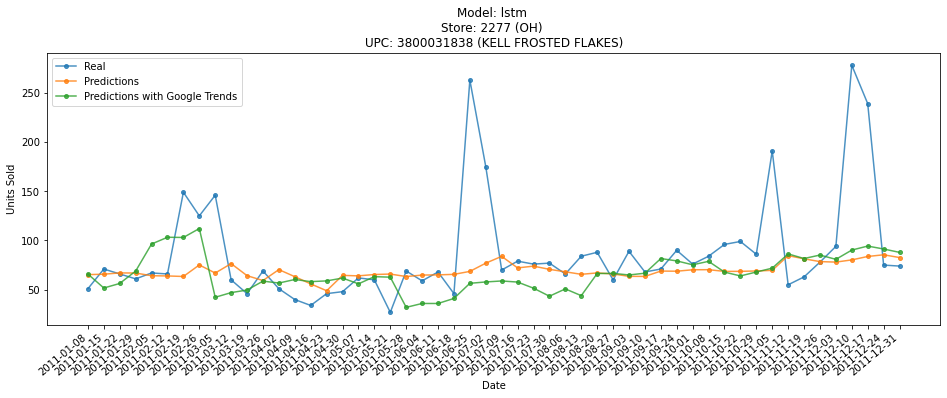

Std lstm: 7.48 and with Google Trends: 18.52






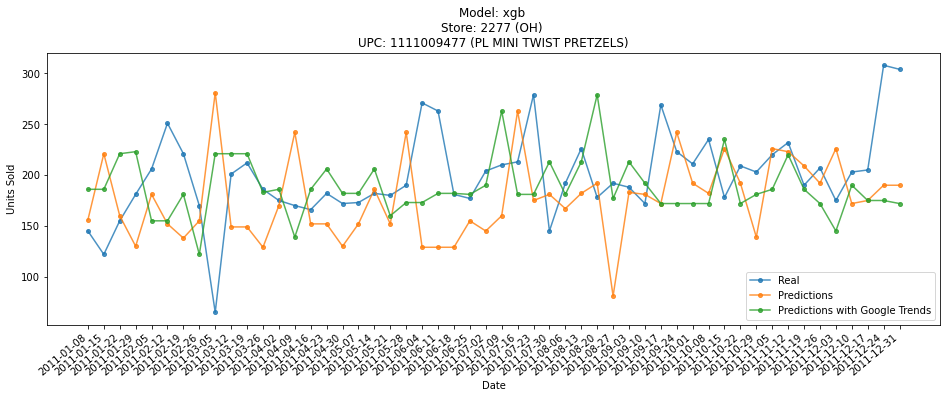

Std xgb: 39.19 and with Google Trends: 28.01


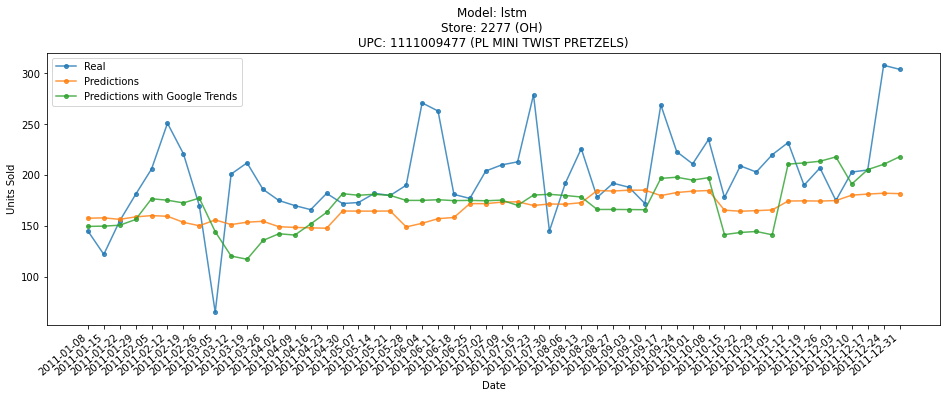

Std lstm: 11.98 and with Google Trends: 24.46






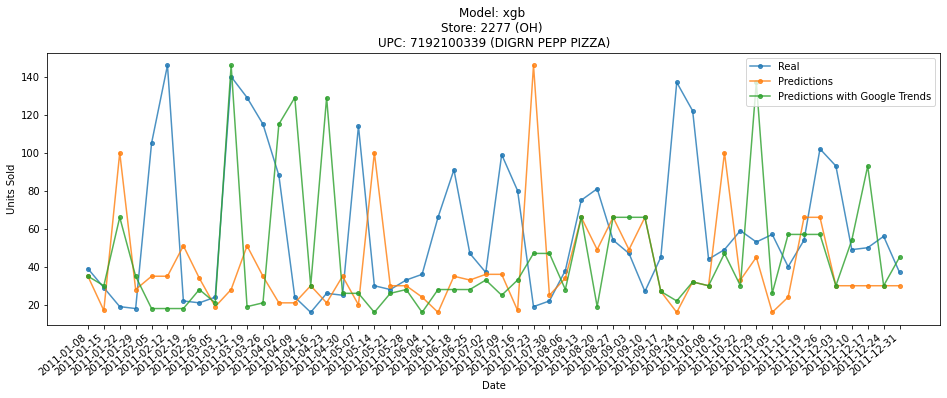

Std xgb: 25.46 and with Google Trends: 32.99


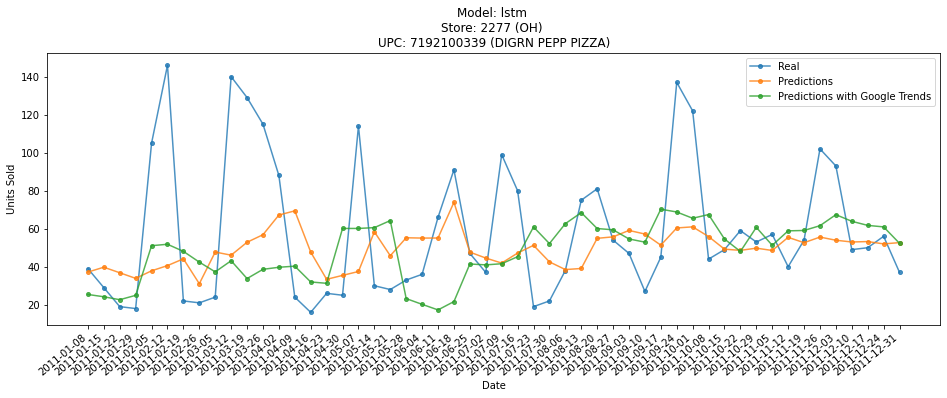

Std lstm: 9.34 and with Google Trends: 15.14






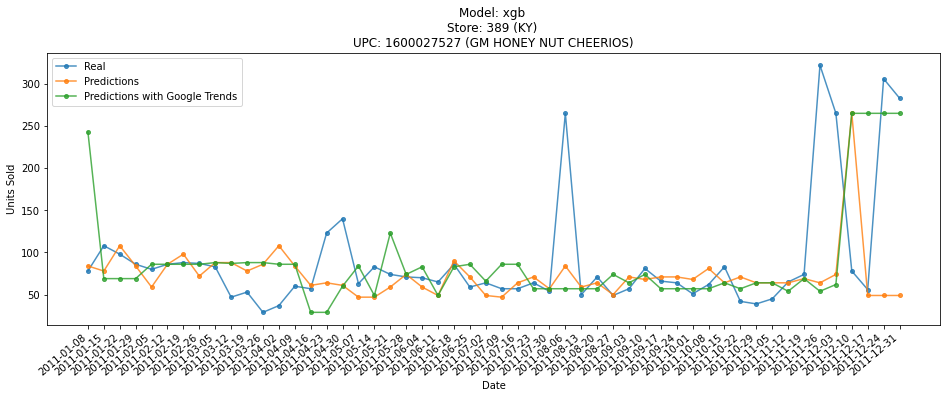

Std xgb: 31.03 and with Google Trends: 59.22


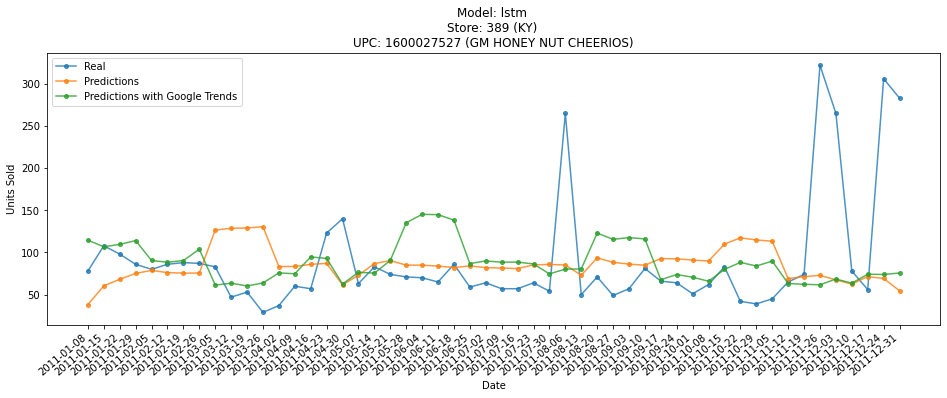

Std lstm: 19.00 and with Google Trends: 22.86






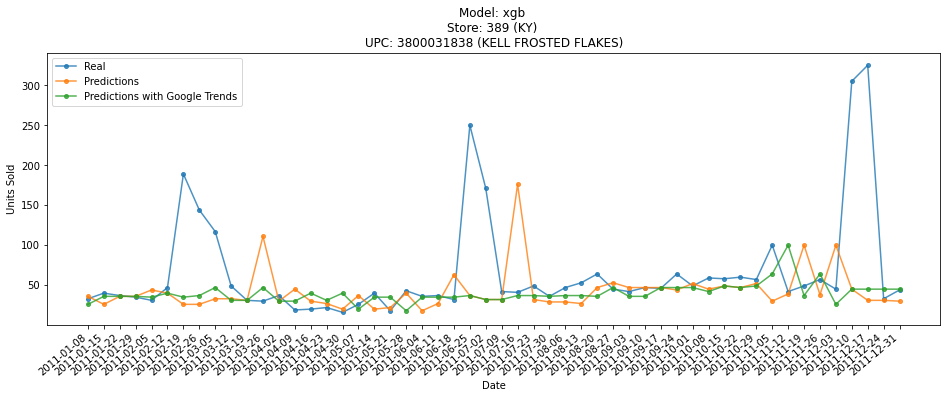

Std xgb: 26.46 and with Google Trends: 12.17


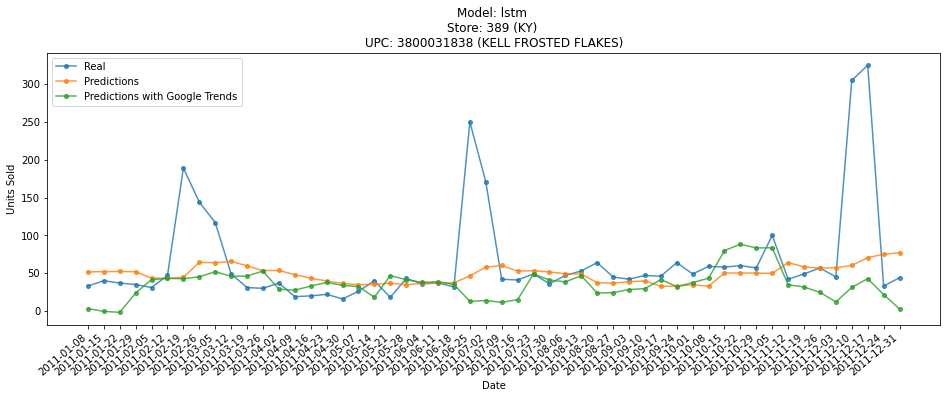

Std lstm: 11.46 and with Google Trends: 19.65






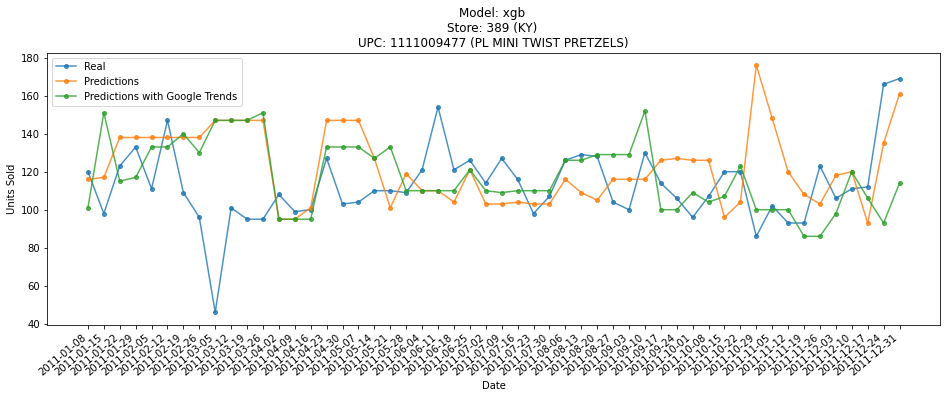

Std xgb: 19.35 and with Google Trends: 17.80


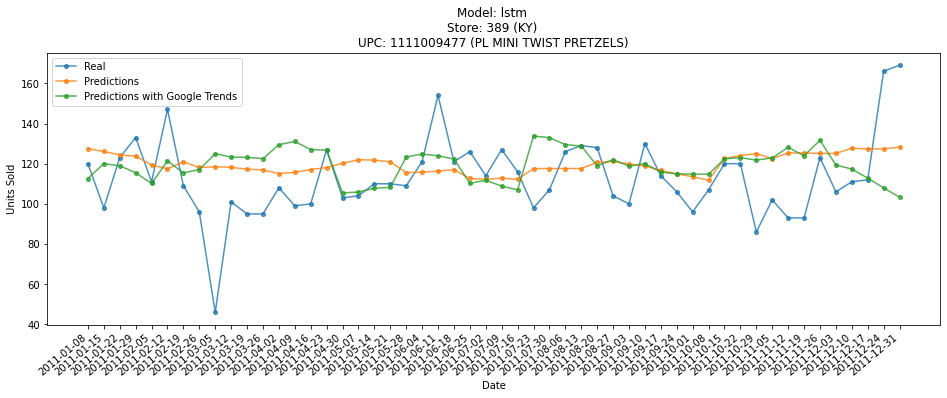

Std lstm: 4.60 and with Google Trends: 7.79






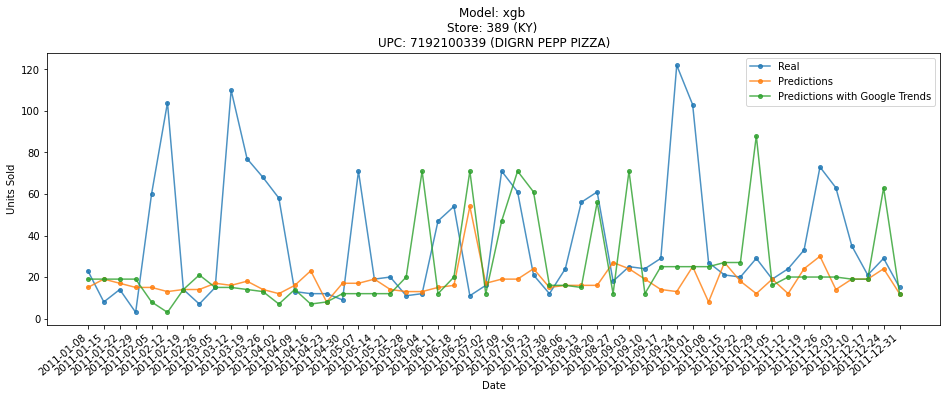

Std xgb: 6.92 and with Google Trends: 20.43


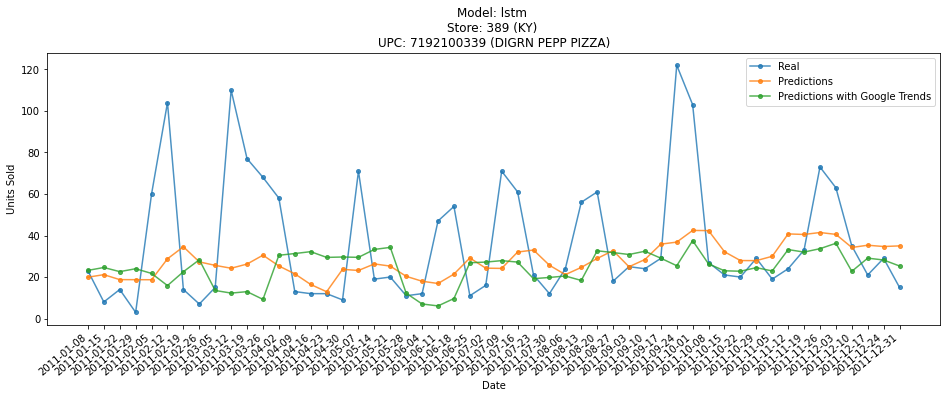

Std lstm: 7.43 and with Google Trends: 7.80






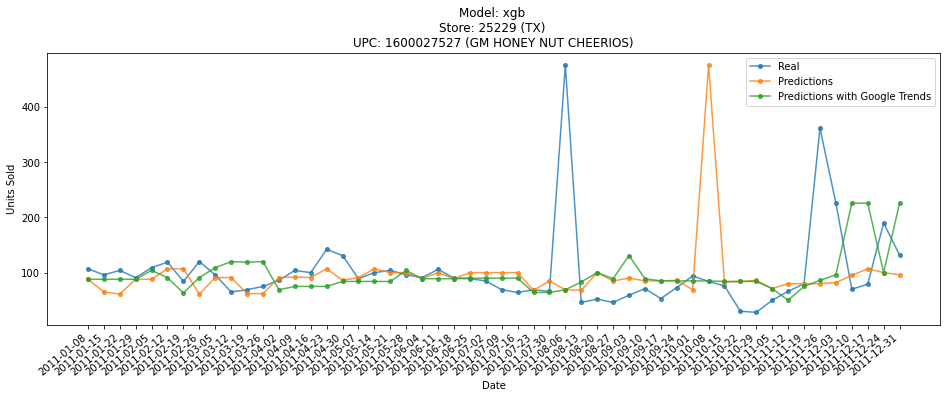

Std xgb: 55.48 and with Google Trends: 35.83


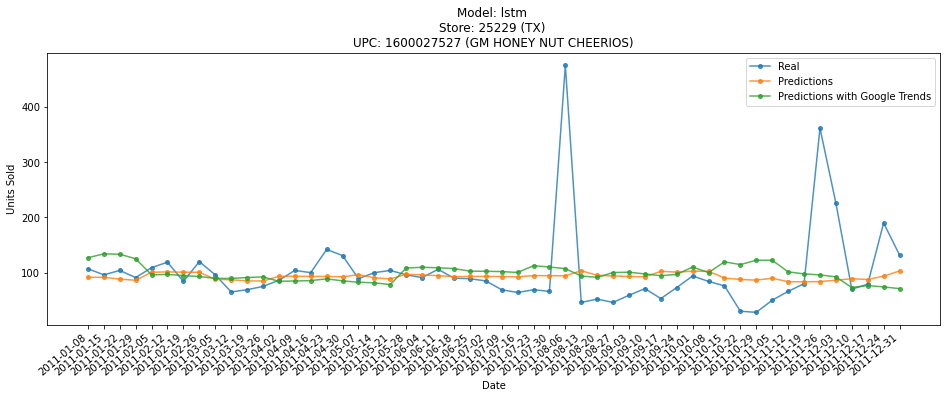

Std lstm: 5.56 and with Google Trends: 15.06






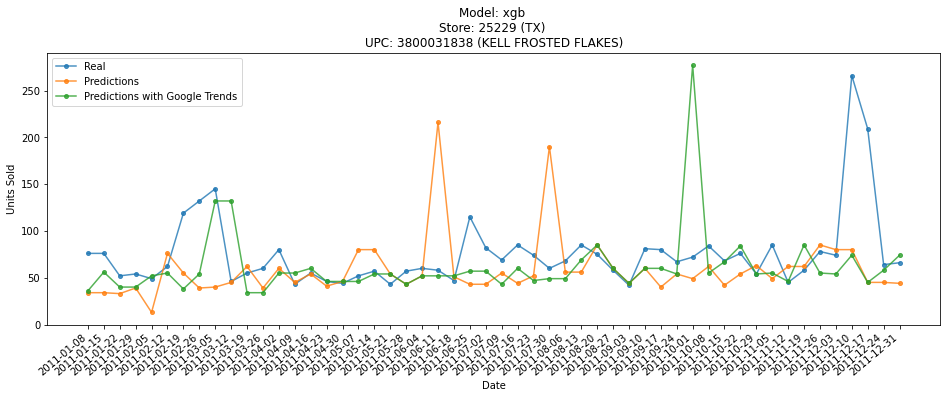

Std xgb: 32.76 and with Google Trends: 35.93


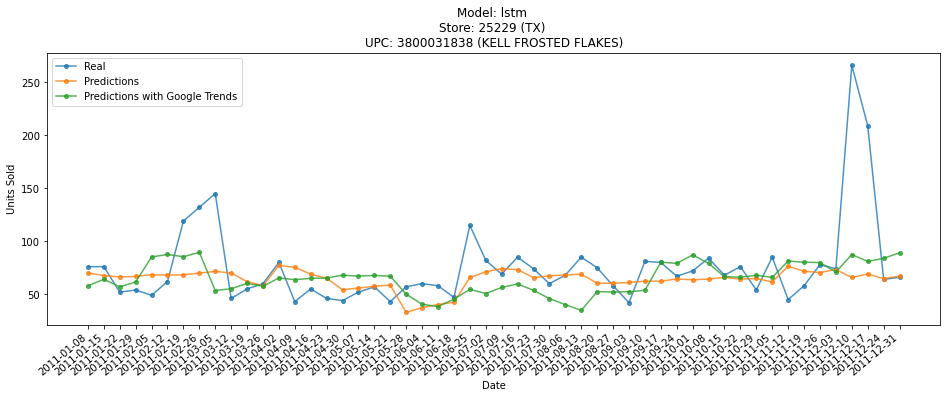

Std lstm: 9.15 and with Google Trends: 14.64






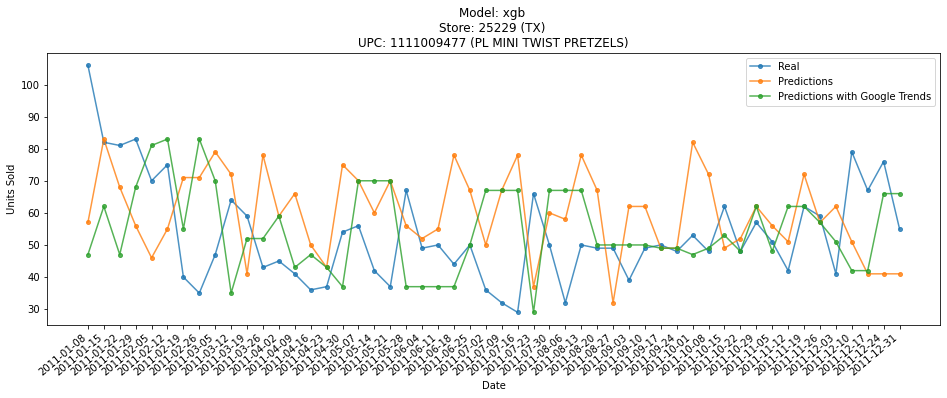

Std xgb: 12.72 and with Google Trends: 12.97


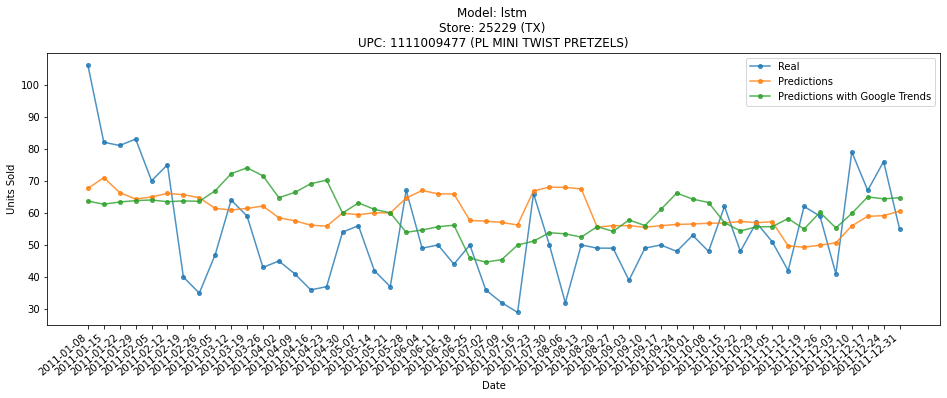

Std lstm: 5.22 and with Google Trends: 6.69






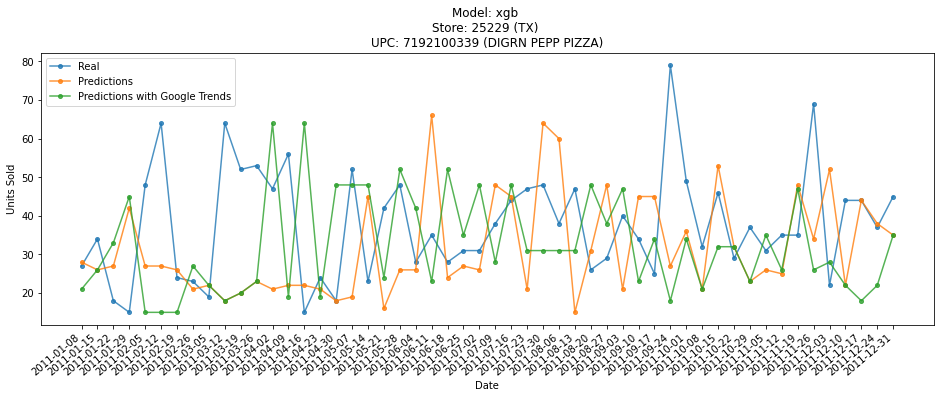

Std xgb: 12.96 and with Google Trends: 12.69


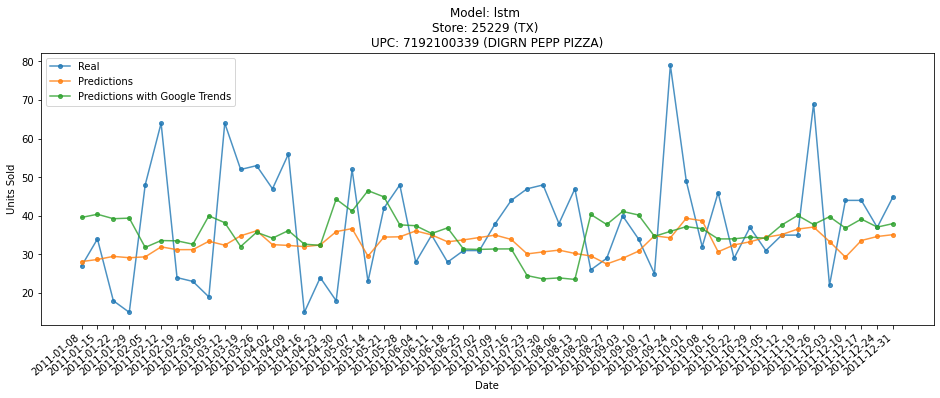

Std lstm: 2.78 and with Google Trends: 4.96






In [13]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
        
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        plt.title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        plt.xlabel('Date')
        plt.ylabel('Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')


In [66]:
# When we add google trends, there seem to be more variation in the predictions

# Statistical Test

In [18]:
from scipy import stats

In [20]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)    30.1742    28.6665          1.507656
(389, 1600027527)    78.5149    76.2193          2.295623
(389, 3800031838)     77.003    70.9188          6.084165
(389, 7192100339)    36.0187     38.495         -2.476313
(2277, 1111009477)   66.1407    56.2195          9.921208
(2277, 1600027527)   102.982    99.7426          3.239615
(2277, 3800031838)   63.8657    72.2577         -8.391991
(2277, 7192100339)   51.3191    51.7001         -0.380997
(25229, 1111009477)  22.6036     21.146          1.457595
(25229, 1600027527)  94.0451    83.4229         10.622173
(25229, 3800031838)  54.1581       52.3          1.858081
(25229, 7192100339)  20.7772    22.3211         -1.543877
std                   27.237    25.2187          5.241483
average              58.1335    56.1175          2.016078
p_value                    -          -          0.209664

In [21]:
# LSTM

paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend']
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    20.8424     23.8337           -2.991255
(389, 1600027527)     77.454     75.4711            1.982898
(389, 3800031838)    65.7201     74.7466           -9.026469
(389, 7192100339)    29.7248     33.3912           -3.666443
(2277, 1111009477)   51.7109     47.1599            4.550989
(2277, 1600027527)   97.9523     99.0187           -1.066348
(2277, 3800031838)   54.0854     55.2182           -1.132794
(2277, 7192100339)   36.8017     38.2474           -1.445635
(25229, 1111009477)  16.0899     16.6399           -0.549956
(25229, 1600027527)  74.0162     75.9035           -1.887240
(25229, 3800031838)   40.005     39.2624            0.742648
(25229, 7192100339)  14.5259     15.8795           -1.353610
std                  26.6344     26.7294            3.280129
average              48.2441     49.5643           -1.320268
p_value                    -           -            0.190744